# Day 1
## MLP
* Build intuition by coding an MLP without frameworks. 
* Lock in tensor shapes and loss definitions. 

### Task
1. Implement a 2-layer MLP (D -> H -> C) with ReLU and softmax (NumPy)
2. Write cross_entropy and softmax logits (stable version: shift by max)
3. Ad L2 regularization to the loss. 

**Checks**
* Unit test: feed a tiny batch with hand-computed outputs
* Verify that loss decreases with a single manual gradient step
* Derive backprop.

In [ ]:
import numpy as np
from utils import ReLU, softmax, cross_entropy

class MLP:
    """A simple 2-layer Multi-Layer Perceptron (MLP) class."""

    def __init__(self, D, H, C, W1=None, b1=None, W2=None, b2=None, dtype=np.float32, seed=None) -> None: # noqa: PLR0913
        """Initialize the MLP with given dimensions and optional weights and biases.

        Args:
            D (_type_): Data input nodes. 
            H (_type_): Hidden nodes.
            C (_type_): Number of concents. One-hot encoded output. 
            W1 (_type_, optional): _description_. Defaults to None.
            b1 (_type_, optional): _description_. Defaults to None.
            W2 (_type_, optional): _description_. Defaults to None.
            b2 (_type_, optional): _description_. Defaults to None.

        """
        self.D, self.H, self.C = D, H, C
        self.dtype = dtype

        if seed is not None:
            rng = np.random.default_rng(seed)
            def randn(*s) -> np.ndarray:
                """Generate random numbers with the specified shape and dtype."""
                return rng.standard_normal(size=s).astype(dtype)
        else:
            def randn(*s) -> np.ndarray:
                """Generate random numbers with the specified shape and dtype."""
                return np.random.randn(*s).astype(dtype)

        # He init 
        self.W1 = W1.astype(dtype) if W1 is not None else randn(D, H) * np.sqrt(2.0 / D)
        self.b1 = b1.astype(dtype) if b1 is not None else np.zeros(H, dtype=dtype)
        self.W2 = W2.astype(dtype) if W2 is not None else randn(H, C) * np.sqrt(2.0 / H)
        self.b2 = b2.astype(dtype) if b2 is not None else np.zeros(C, dtype=dtype)


    def logits(self, X: np.ndarray) -> np.ndarray: # noqa: N803
        """Compute the logits (raw output) of the MLP.

        Args:
            X (np.ndarray): Input data.

        Returns:
            np.ndarray: The logits of the MLP.

        """
        X = X.astype(self.dtype, copy=False)  # Ensure input is in the correct dtype
        y1 = X @ self.W1 + self.b1 # (N, H)
        y1 = ReLU(y1) # (N, H)
        y2 = y1 @ self.W2 + self.b2 # (N, C)
        return y2


    def forward(self, X) -> np.ndarray:
        """Forward pass through the MLP.

        Args:
            X (_type_): _description_

        Returns:
            _type_: _description_

        """
        return softmax(self.logits(X))

    def loss(self, X:np.ndarray, y:np.ndarray, l2: float = 0.0) -> float:
        """Compute the cross-entropy loss with l2 regularization.

        Args:
            X (np.ndarray): Input data.
            y (np.ndarray): True labels.
            l2 (float, optional): L2 regularization strength. Defaults to 0.0.

        Returns:
            float: The computed loss value.

        """
        z = self.logits(X)
        ce = cross_entropy(z, y)
        l2_reg = 0.5*l2*(np.sum(self.W1**2) + np.sum(self.W2**2)) # L2 regularization term on weights
        return float(ce + l2_reg)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict class probabilities for the input data.

        Args:
            X (np.ndarray): Input data.

        Returns:
            np.ndarray: Predicted class probabilities.

        """
        return self.forward(X)/ np.sum(self.forward(X), axis=1, keepdims=True)


    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels for the input data.

        Args:
            X (np.ndarray): Input data.

        Returns:
            np.ndarray: Predicted class labels.

        """
        return np.argmax(self.predict_proba(X), axis=1)


    def accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """Compute the accuracy of the model on the given data.

        Args:
            X (np.ndarray): Input data.
            y (np.ndarray): True labels.

        Returns:
            float: The accuracy of the model.

        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


    def sgd_step(self, X:np.ndarray, y:np.ndarray, lr:float = 1e-2, l2:float = 0.0) -> float: 
        """Perform a single SGD step on a batch (X,y).

        Args:
            X (np.ndarray): Data
            y (np.ndarray): target. Can be (N,) integer labels or (N,C) one hot
            lr (float, optional): _description_. Defaults to 1e-2.
            l2 (float, optional): _description_. Defaults to 0.0.

        Returns: current loss

        """
        N = X.shape[0]
        C = self.C 

        # --- Forward ---
        a1 = X@ self.W1 + self.b1
        h = ReLU(a1)
        z = h @ self.W2 + self.b2

        # stable softmax
        z_shift = z - z.max(axis=1, keepdims=True)
        expz = np.exp(z_shift)
        p = expz/expz.sum(axis=1, keepdims=True)

        # --- Prepare labels ---
        if y.ndim == 1: 
            y_onehot = np.eye(C, dtype=p.dtype)[y] # (N, C)
        elif y.ndim == 2 and y.shape == p.shape: # noqa: PLR2004
            y_onehot = y
        else: 
            raise ValueError("y most be (N,) ints or (N, C) one-hot.")

        # --- Backprop ---
        dz = (p - y_onehot) / N  # <--- softmax derivative? 

        dW2 = h.T @ dz
        db2 = dz.sum(axis=0)

        dh = dz @ self.W2.T
        da1 = dh * (a1 > 0)

        dW1 = X.T @ da1
        db1 = da1.sum(axis=0)

        if l2 > 0.0: 
            dW2 += l2*self.W2
            dW1 += l2*self.W1


        # --- Param update ----
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

        return self.loss(X, y, l2=l2)


## Tests

In [28]:
mlp = MLP(D=2, H=10, C=2, seed=42)
X = np.array([[1,0], [0,1], [1,1], [0,0]])
y = np.array([[1,0], [1,0], [0,1], [0,1]])

L2 = 0.0
LR = 0.5

losses = []
for _ in range(200):
    loss = mlp.loss(X,y,l2=L2)
    losses.append(loss)
    mlp.sgd_step(X,y, lr=LR, l2=L2)

Text(0, 0.5, 'Loss')

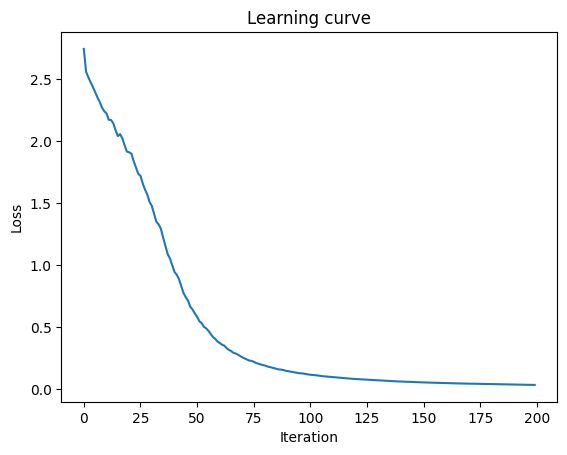

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Learning curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")


In [29]:
mlp.predict_proba(X)

array([[0.98849299, 0.01150701],
       [0.99214326, 0.00785674],
       [0.0028644 , 0.9971356 ],
       [0.00999406, 0.99000594]])

### Additional

- Finite difference check backprop
- log-sum-exp trick (review)
- Learn Rate finder - picks the largest LR before loss spikes, then train with +/- 1/3 of that and add decay.
- Early flattening of the learning curve - L2 too high or a capacity issue.
- No oscillation in the learning curve - LR isn't too high
- Keeps falling past 0.1 -> not capacity limited. 

In [12]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")



NameError: name 'losses' is not defined